Import và cấu hình

In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from torchvision import transforms
import seaborn as sns
import random
from collections import Counter

# Cấu hình
dataset_path = r'C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset'  # Thay bằng đường dẫn thật
img_size = (64, 64)
categories = sorted(os.listdir(dataset_path))
print(f"Found {len(categories)} categories: {categories}")


Found 25 categories: ['apple', 'bowtie', 'circle', 'cloud', 'cup', 'diamond', 'fish', 'guitar', 'hat', 'headphones', 'ladder', 'laptop', 'leaf', 'moon', 'pants', 'pencil', 'rectangle', 'soccer_ball', 'sock', 'star', 'sun', 't-shirt', 'triangle', 'watermelon', 'wine glass']


Load và đếm dữ liệu

C:\Users\PC\AppData\Local\Temp\ipykernel_14496\3907486191.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data_count.keys()), y=list(data_count.values()), palette="viridis")


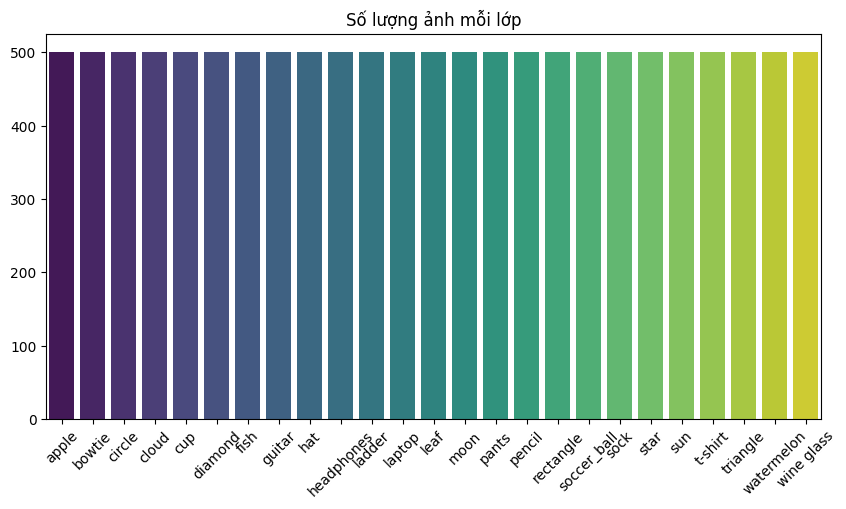

In [105]:
# Đếm số lượng ảnh mỗi lớp
data_count = {}
for c in categories:
    folder = os.path.join(dataset_path, c)
    count = len(os.listdir(folder))
    data_count[c] = count

# Trực quan hóa số lượng ảnh mỗi lớp
plt.figure(figsize=(10,5))
sns.barplot(x=list(data_count.keys()), y=list(data_count.values()), palette="viridis")
plt.title("Số lượng ảnh mỗi lớp")
plt.xticks(rotation=45)
plt.show()

# total_images = sum(data_count.values())
# for c, count in data_count.items():
#     print(f"{c}: {count} ảnh ({count/total_images*100:.2f}%)")


Kiểm tra kích thước và tỉ lệ ảnh

In [106]:
# img_shapes = []
# for c in categories:
#     folder = os.path.join(dataset_path, c)
#     for img_name in os.listdir(folder)[:50]:
#         img = Image.open(os.path.join(folder, img_name)).convert("L")
#         img_shapes.append(img.size)

# sizes = np.array(img_shapes)
# plt.figure(figsize=(6,4))
# plt.scatter(sizes[:,0], sizes[:,1], alpha=0.6)
# plt.title("Kích thước ảnh (width, height)")
# plt.xlabel("Width"); plt.ylabel("Height")
# plt.show()

# unique_sizes = set(img_shapes)
# print(f"Tổng số kích thước khác nhau: {len(unique_sizes)}")


Tổng số kích thước khác nhau: 8
  455x227: 585 ảnh (46.80%)
  475x309: 241 ảnh (19.28%)
  64x64: 200 ảnh (16.00%)
  408x293: 121 ảnh (9.68%)
  1668x2154: 50 ảnh (4.00%)
  627x563: 30 ảnh (2.40%)
  421x293: 22 ảnh (1.76%)
  423x393: 1 ảnh (0.08%)


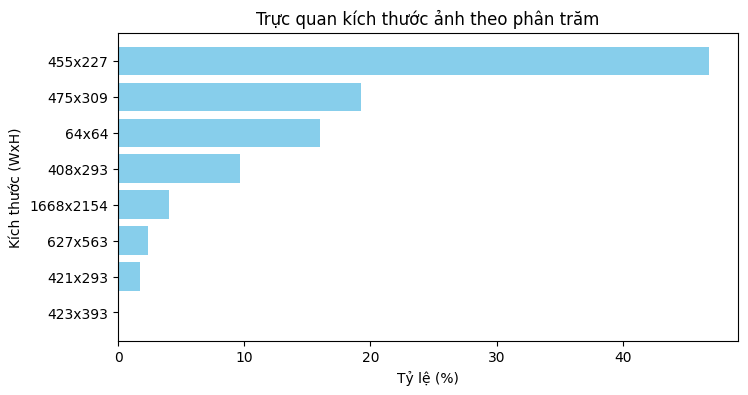

In [107]:

# --- Lấy kích thước ảnh ---
img_shapes = []
for c in categories:
    folder = os.path.join(dataset_path, c)
    for img_name in os.listdir(folder)[:50]:
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("L")
            img_shapes.append(img.size)
        except Exception as e:
            print(f"Lỗi khi đọc {img_path}: {e}")

# --- Đếm tần suất mỗi kích thước ---
shape_counts = Counter(img_shapes)
total_images = sum(shape_counts.values())

# Tạo mảng dữ liệu để trực quan
sizes = np.array(list(shape_counts.keys()))
counts = np.array(list(shape_counts.values()))
percents = counts / total_images * 100

# --- In thống kê ---
print(f"Tổng số kích thước khác nhau: {len(shape_counts)}")
for (w, h), cnt in shape_counts.most_common(len(shape_counts)):
    print(f"  {w}x{h}: {cnt} ảnh ({cnt/total_images*100:.2f}%)")

# --- Biểu đồ thanh  ---
top10 = shape_counts.most_common(len(shape_counts))
labels = [f"{w}x{h}" for (w, h), _ in top10]
values = [v for _, v in top10]
percent_values = [v / total_images * 100 for v in values]


plt.figure(figsize=(8,4))
plt.barh(labels, percent_values, color='skyblue')
plt.xlabel("Tỷ lệ (%)")
plt.ylabel("Kích thước (WxH)")
plt.title("Trực quan kích thước ảnh theo phân trăm")
plt.gca().invert_yaxis()
plt.show()


Chuẩn hóa ảnh về (64,64) & xử lý nét

In [108]:
import os
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
import random

# --- Cấu hình ---
dataset_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset"                 # thư mục gốc chứa dataset
output_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\processed_line_resize_dataset"        # nơi lưu ảnh đã xử lý
img_size = (64, 64)                      # resize về kích thước cố định

# --- Danh sách nhãn ---
categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# --- Hàm xử lý ảnh ---
def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")  # chuyển sang grayscale
    img = ImageOps.invert(img)               # đảo ngược màu (nền đen, nét trắng)
    img = img.resize(img_size)               # chuẩn hóa kích thước
    img = ImageEnhance.Contrast(img).enhance(5.0)  # tăng tương phản
    return img

# --- Xử lý toàn bộ dataset ---
for category in categories:
    input_folder = os.path.join(dataset_path, category)
    output_folder = os.path.join(output_path, category)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Đang xử lý category: {category}")
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        output_img_path = os.path.join(output_folder, img_name)

        try:
            img = preprocess_image(img_path)
            img.save(output_img_path)
        except Exception as e:
            print(f"Lỗi ở ảnh {img_name}: {e}")

print("Hoàn tất xử lý toàn bộ dataset!")




Đang xử lý category: apple
Đang xử lý category: bowtie
Đang xử lý category: circle
Đang xử lý category: cloud
Đang xử lý category: cup
Đang xử lý category: diamond
Đang xử lý category: fish
Đang xử lý category: guitar
Đang xử lý category: hat
Đang xử lý category: headphones
Đang xử lý category: ladder
Đang xử lý category: laptop
Đang xử lý category: leaf
Đang xử lý category: moon
Đang xử lý category: pants
Đang xử lý category: pencil
Đang xử lý category: rectangle
Đang xử lý category: soccer_ball
Đang xử lý category: sock
Đang xử lý category: star
Đang xử lý category: sun
Đang xử lý category: t-shirt
Đang xử lý category: triangle
Đang xử lý category: watermelon
Đang xử lý category: wine glass
Hoàn tất xử lý toàn bộ dataset!


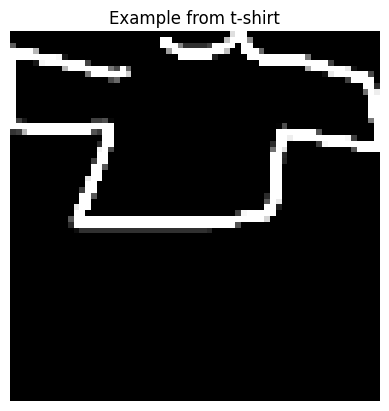

In [109]:
# --- Hiển thị thử một ảnh ngẫu nhiên ---
sample_category = random.choice(categories)
sample_path = os.path.join(output_path, sample_category, random.choice(os.listdir(os.path.join(output_path, sample_category))))
img = Image.open(sample_path)
plt.imshow(img, cmap='gray')
plt.title(f"Example from {sample_category}")
plt.axis('off')
plt.show()

Chuẩn hóa giá trị pixel

In [110]:
# --- Cell: Normalization [0,1] + Visualization + Save ---
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# --- Cấu hình ---
input_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\processed_line_resize_dataset"             # thư mục ảnh đã xử lý (invert, resize, contrast)
output_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\normalized_dataset"           # nơi lưu ảnh đã chuẩn hóa
os.makedirs(output_path, exist_ok=True)

# --- Hàm chuẩn hóa ---
def normalize_image(img_array):
    return img_array.astype("float32") / 255.0

# --- Hàm trực quan ---
def visualize_before_after(img_path):
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    norm_img = normalize_image(img_array)

    # Hiển thị ảnh gốc và ảnh chuẩn hóa
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_array, cmap="gray")
    ax[0].set_title("Ảnh gốc (0–255)")
    ax[0].axis("off")

    ax[1].imshow(norm_img, cmap="gray")
    ax[1].set_title("Ảnh sau khi chuẩn hóa [0,1]")
    ax[1].axis("off")

    plt.show()

    return norm_img

# --- Chuẩn hóa toàn bộ dataset ---
categories = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]

for category in categories:
    input_folder = os.path.join(input_path, category)
    output_folder = os.path.join(output_path, category)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Chuẩn hóa category: {category}")
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        try:
            img = Image.open(img_path).convert("L")
            norm_img = normalize_image(np.array(img))
            
            # Lưu lại ảnh đã chuẩn hóa (nhân lại 255 để lưu được dạng ảnh)
            Image.fromarray((norm_img * 255).astype(np.uint8)).save(os.path.join(output_folder, img_name))
        except Exception as e:
            print(f"Lỗi ở ảnh {img_name}: {e}")

print("Hoàn tất chuẩn hóa toàn bộ dataset!")





Chuẩn hóa category: apple
Chuẩn hóa category: bowtie
Chuẩn hóa category: circle
Chuẩn hóa category: cloud
Chuẩn hóa category: cup
Chuẩn hóa category: diamond
Chuẩn hóa category: fish
Chuẩn hóa category: guitar
Chuẩn hóa category: hat
Chuẩn hóa category: headphones
Chuẩn hóa category: ladder
Chuẩn hóa category: laptop
Chuẩn hóa category: leaf
Chuẩn hóa category: moon
Chuẩn hóa category: pants
Chuẩn hóa category: pencil
Chuẩn hóa category: rectangle
Chuẩn hóa category: soccer_ball
Chuẩn hóa category: sock
Chuẩn hóa category: star
Chuẩn hóa category: sun
Chuẩn hóa category: t-shirt
Chuẩn hóa category: triangle
Chuẩn hóa category: watermelon
Chuẩn hóa category: wine glass
Hoàn tất chuẩn hóa toàn bộ dataset!


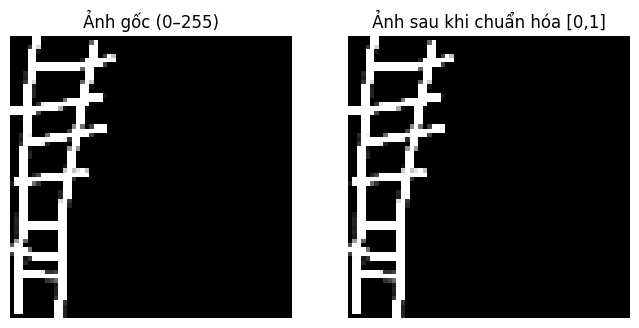

In [111]:
# --- Hiển thị thử một ảnh ngẫu nhiên ---
sample_category = random.choice(categories)
sample_path = os.path.join(input_path, sample_category, random.choice(os.listdir(os.path.join(input_path, sample_category))))
norm_img = visualize_before_after(sample_path)

Tăng cường dữ liệu (Data Augmentation)

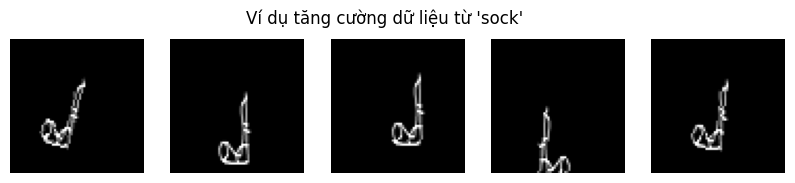

Đang tăng cường dữ liệu cho category: apple
Đang tăng cường dữ liệu cho category: bowtie
Đang tăng cường dữ liệu cho category: circle
Đang tăng cường dữ liệu cho category: cloud
Đang tăng cường dữ liệu cho category: cup
Đang tăng cường dữ liệu cho category: diamond
Đang tăng cường dữ liệu cho category: fish
Đang tăng cường dữ liệu cho category: guitar
Đang tăng cường dữ liệu cho category: hat
Đang tăng cường dữ liệu cho category: headphones
Đang tăng cường dữ liệu cho category: ladder
Đang tăng cường dữ liệu cho category: laptop
Đang tăng cường dữ liệu cho category: leaf
Đang tăng cường dữ liệu cho category: moon
Đang tăng cường dữ liệu cho category: pants
Đang tăng cường dữ liệu cho category: pencil
Đang tăng cường dữ liệu cho category: rectangle
Đang tăng cường dữ liệu cho category: soccer_ball
Đang tăng cường dữ liệu cho category: sock
Đang tăng cường dữ liệu cho category: star
Đang tăng cường dữ liệu cho category: sun
Đang tăng cường dữ liệu cho category: t-shirt
Đang tăng cường dữ

In [112]:
# --- Cell: Data Augmentation ---
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# --- Cấu hình ---
input_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\normalized_dataset"          # thư mục ảnh đã chuẩn hóa [0,1]
output_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\augmented_dataset"          # nơi lưu ảnh tăng cường dữ liệu
os.makedirs(output_path, exist_ok=True)

# --- Pipeline transform ---
transform = transforms.Compose([
    transforms.RandomRotation(20),                  # xoay ±20°
    transforms.RandomHorizontalFlip(),              # lật ngang ngẫu nhiên
    transforms.RandomAffine(0, translate=(0.2,0.2)) # tịnh tiến nhẹ
])

# --- Lấy danh sách category ---
categories = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]

# --- Chọn ảnh ngẫu nhiên để trực quan ---
sample_category = random.choice(categories)
sample_folder = os.path.join(input_path, sample_category)
sample_img_path = os.path.join(sample_folder, random.choice(os.listdir(sample_folder)))

img = np.array(Image.open(sample_img_path).convert("L"))

# --- Trực quan hoá 5 ảnh tăng cường từ cùng 1 ảnh ---
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    aug_img = transform(Image.fromarray(img))
    axes[i].imshow(aug_img, cmap="gray")
    axes[i].axis("off")
plt.suptitle(f"Ví dụ tăng cường dữ liệu từ '{sample_category}'")
plt.show()

# --- Áp dụng augment cho toàn bộ dataset ---
for category in categories:
    input_folder = os.path.join(input_path, category)
    output_folder = os.path.join(output_path, category)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Đang tăng cường dữ liệu cho category: {category}")
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        try:
            img = Image.open(img_path).convert("L")

            # Sinh ra 3 ảnh tăng cường (bạn có thể đổi số lượng)
            for i in range(3):
                aug_img = transform(img)
                aug_img.save(os.path.join(output_folder, f"aug_{i}_{img_name}"))

        except Exception as e:
            print(f"Lỗi ở ảnh {img_name}: {e}")

print("Hoàn tất tăng cường dữ liệu toàn bộ dataset!")


trực quan hóa

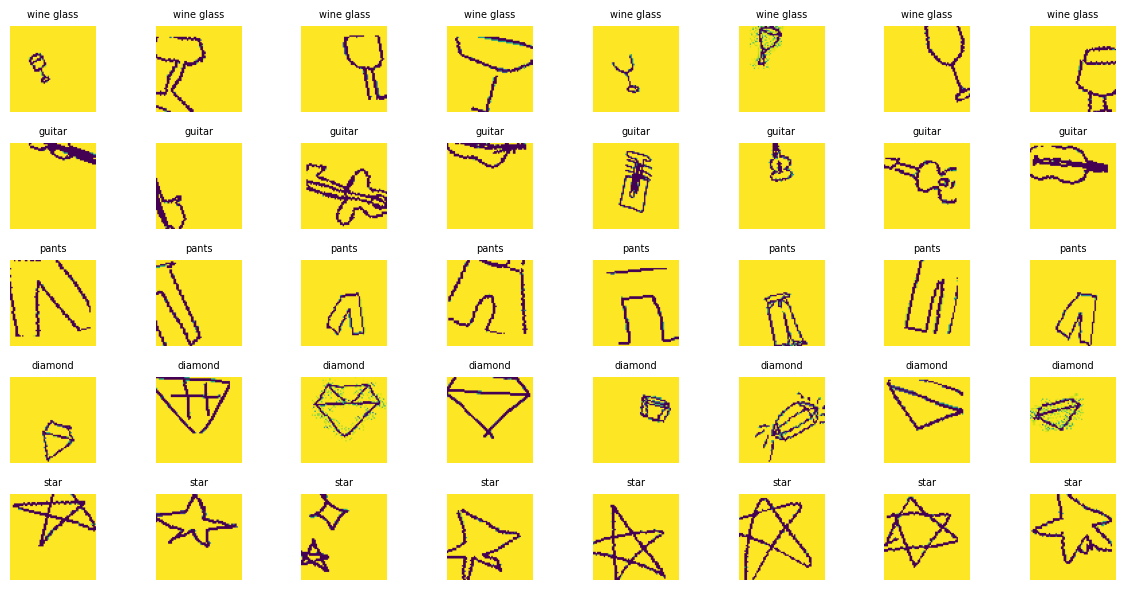

In [113]:
def show_grid(dataset_path, n=40):
    all_imgs = []
    all_labels = []
    for c in random.sample(categories, 5):
        folder = os.path.join(dataset_path, c)
        imgs = random.sample(os.listdir(folder), n // 5)
        for im in imgs:
            path = os.path.join(folder, im)
            all_imgs.append(preprocess_image(path))
            all_labels.append(c)
    fig, axes = plt.subplots(5, n//5, figsize=(12,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(all_imgs[i], cmap='viridis')
        ax.set_title(all_labels[i], fontsize=7)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

dataset_path = r'C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\augmented_dataset'
show_grid(dataset_path)

In [114]:
# def show_class_mean(dataset_path, categories, img_size):
#     fig, axes = plt.subplots(2, 5, figsize=(10,5))
#     for i, c in enumerate(random.sample(categories, 10)):
#         folder = os.path.join(dataset_path, c)
#         imgs = [preprocess_image(os.path.join(folder, img)) for img in random.sample(os.listdir(folder), 50)]
#         mean_img = np.mean(imgs, axis=0)
#         ax = axes[i//5, i%5]
#         ax.imshow(mean_img, cmap='viridis')
#         ax.set_title(c)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# dataset_path = r'C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\augmented_dataset'
# show_class_mean(dataset_path, categories, img_size)
